# Parsing and Recombining Inputs

In the chapter on [Grammars](Grammars.ipynb), we discussed how grammars can be
used to represent various languages. We also saw how grammars can be used to
generate strings of the corresponding language. Grammars can also perform the
reverse. That is, given a string, one can decompose the string into its
constituent parts that correspond to the parts of grammar used to generate it
-- the derivation tree of that string. These parts (and parts from other similar
strings) can later be recombined using the same grammar to produce new strings.

In this chapter, we use grammars to parse and decompose inputs to
their corresponding derivation trees, allowing us to recombine them
arbitrarily.

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* An understanding of derivation trees from the [chapter on grammar fuzzer](GrammarFuzzer.ipynb)
  is also required.

In [1]:
import fuzzingbook_utils

In [2]:
from Grammars import EXPR_GRAMMAR, START_SYMBOL, RE_NONTERMINAL, is_valid_grammar
from Fuzzer import Fuzzer
from GrammarFuzzer import GrammarFuzzer
from ExpectError import ExpectError

In [3]:
from IPython.display import display

We define extended versions of `display_tree` and `all_terminals` here.

In [4]:
import re
from graphviz import Digraph


def annotated_symbol(s, a):
    return re.sub(r'([^a-zA-Z0-9" ])', r"\\\1", s) + (" (%s)" % a if a else '')


def annotated_node(node, id):
    symbol, children, *annotation = node
    return symbol, children, ''.join(str(a) for a in annotation)


def display_tree(derivation_tree,
                           annotated_node=annotated_node,
                           annotate=annotated_symbol):
    counter = 0

    def traverse_tree(dot, tree, id=0):
        (symbol, children, annotation) = annotated_node(tree, id)
        dot.node(repr(id), annotate(symbol, annotation))

        if children is not None:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                dot.edge(repr(id), repr(child_id))
                traverse_tree(dot, child, child_id)

    dot = Digraph(comment="Derivation Tree")
    dot.attr('node', shape='plain')
    traverse_tree(dot, derivation_tree)
    display(dot)
    
def all_terminals(tree, grammar=None):
    symbol, children, *_ = tree
    if children:
        return ''.join(all_terminals(c, grammar) for c in children)
    else:
        if grammar is not None:
             return '' if symbol in grammar else symbol
        else:
            return symbol

In order to parse a string, one needs to identify the language, and the
corresponding grammar. For example, here is a string that we would like to parse

In [5]:
mystring = '1+2'

This string is an arithmetic expression for addition, which may be specified using a grammar.

## Grammars

A grammar, as you have read from the [chapter on grammars](Grammars.ipynb) is a set of _rules_ that explain how the start symbol can be expanded. Each rule has a name, also called a _nonterminal_, and a set of _alternative choices_ in how the nonterminal can be expanded.

In [6]:
A1_GRAMMAR = {
    "<start>": ["<expr>"],
    "<expr>": ["<expr>+<expr>", "<expr>-<expr>", "<integer>"],
    "<integer>": ["<digit><integer>", "<digit>"],
    "<digit>": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

In the above expression, the rule `<expr> : <expr>+<expr>|<expr>-<expr>|<int>` corresponds to how the nonterminal `<expr>` might be expanded.  The expression `<expr>+<expr>` corresponds to one of the alternative choices. We call this an _alternative_ expansion for the nonterminal `<expr>`. Finally, in an expression `<expr>+<expr>`, each of `<expr>`, `+`, and `<expr>` are _symbols_ in that expansion. A symbol could be either a nonterminal or a terminal symbol based on whether its expansion is available in the grammar.

The _derivation tree_ for our expression from this grammar is given by:

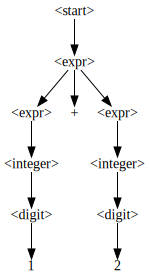

In [7]:
tree = ('<start>', [('<expr>',
                     [('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
                      ('+', []),
                      ('<expr>', [('<integer>', [('<digit>', [('2',
                                                               [])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

While a grammar can be used to specify a given language, there could be multiple
grammars that correspond to the same language. For example, here is another 
grammar to describe the same addition expression.

In [8]:
A2_GRAMMAR = {
    "<start>": ["<expr>"],
    "<expr>": ["<integer><expr_>"],
    "<expr_>": ["+<expr>", "-<expr>", ""],
    "<integer>": ["<digit><integer_>"],
    "<integer_>": ["<integer>", ""],
    "<digit>": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

The corresponding derivation tree is given by:

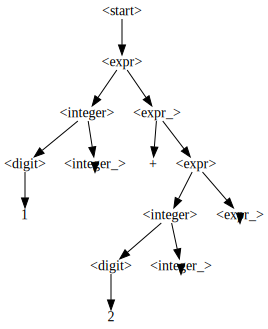

In [9]:
tree = ('<start>', [('<expr>', [('<integer>', [('<digit>', [('1', [])]),
                                               ('<integer_>', [('', [])])]),
                                ('<expr_>', [('+', []),
                                             ('<expr>',
                                              [('<integer>',
                                                [('<digit>', [('2', [])]),
                                                 ('<integer_>', [('', [])])]),
                                               ('<expr_>', [('', [])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

Indeed, there could be different classes of grammars that
describe the same language. For example, the first grammar `A1_GRAMMAR`
is a grammar that sports both _right_ and _left_ recursion, while the
second grammar `A2_GRAMMAR` does not have left recursion in the
nonterminals in any of its productions, but contains _epsilon_ productions.
(An epsilon production is a production that has empty string in its right
hand side.)

#### Recursion

A grammar is _left recursive_ if any of its nonterminals are left recursive,
and a nonterminal is directly left-recursive if the left-most symbol of
any of its productions is itself. It is indirectly left-recursive if any
of the left-most symbols can be expanded using their definitions to
produce the nonterminal as the left-most symbol of the expansion. The left
recursion is called a _hidden-left-recursion_ if during the series of
expansions of  a nonterminal, one reaches a rule where the rule contains
the same nonterminal after a prefix of other symbols, and these symbols can
dervive the empty string. For example, in `A1_GRAMMAR`, `<integer>` will be
considered hidden-left recursive if `<digit>` could derive an empty string.

Right recursive grammars are defined similarly.

For example, in `A1_GRAMMAR`, the definition of `<expr>` is
left-recursive, and right recursive directly. However in `A2_GRAMMAR`,
`<expr>` is right recursive indirectly through the expansion of `<expr_>`.

#### Ambiguity

To complicate matters further, there could be
multiple derivation trees -- also called _parses_ -- corresponding to the
same string from the same grammar. For example, a string `1+2+3` can be parsed
in two ways as we see below using the `A1_GRAMMAR`

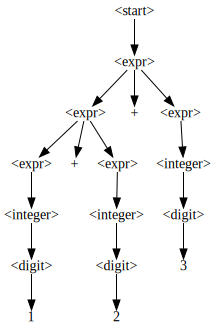

In [10]:
mystring = '1+2+3'
tree = ('<start>',
        [('<expr>',
          [('<expr>', [('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
                       ('+', []),
                       ('<expr>', [('<integer>',
                                    [('<digit>', [('2', [])])])])]), ('+', []),
           ('<expr>', [('<integer>', [('<digit>', [('3', [])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

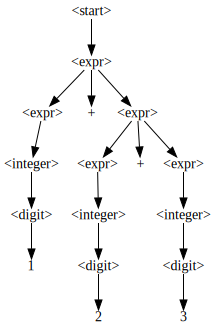

In [11]:
tree = ('<start>',
        [('<expr>', [('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
                     ('+', []),
                     ('<expr>',
                      [('<expr>', [('<integer>', [('<digit>', [('2', [])])])]),
                       ('+', []),
                       ('<expr>', [('<integer>', [('<digit>', [('3',
                                                                [])])])])])])])
assert all_terminals(tree) == mystring
display_tree(tree)

Numerous parsing techniques exist that can parse a given string using a
given grammar, and produce corresponding derivation tree or trees. However,
some of these techniques work only on specific classes of grammars.
These classes of grammars are named after the specific kind of parser
that can accept grammars of that category. That is, the upper bound for
the capabilities of the parser defines the grammar class named after that
parser.

Different classes of grammars differ in the features that are available to
the user for writing a grammar of that class. That is, the corresponding
kind of parser will be unable to parse a grammar that makes use of more
features than allowed. For example, the `A2_GRAMMAR` is an *LL*
grammar because it lacks left recursion, while `A1_GRAMMAR` is not an
*LL* grammar. This is because an *LL* parser is a parser that parses
its input from left to right, and constructs a leftmost derivation of its
input by expanding the nonterminals it encounters. If there is a left
recursion in one of these rules, an *LL* parser will enter an infinite loop.

Next, we develop different parsers. To do that, we define a minimal interface for parsing, that is obeyed by all parsers. There are two approaches to parsing a string using a grammar.

The traditional approach is to use a *lexer* (also called a *tokenizer* or a *scanner*) to first tokenize the incoming string, and feed the grammar one token at a time. The lexer is typically a smaller parser that accepts a *regular language*. The advantage of this approach is that the grammar used by the parser can eschew the details of tokenization. Further, one gets a shallow derivation tree at the end of the parsing which can be directly used for generating the *Abstract Syntax Tree*.

The second approach is to use a tree pruner after the complete parse. With this approach, one uses a grammar that incorporates complete details of the syntax. Next, the nodes corresponding to tokens are pruned and replaced with their corresponding strings as leaf nodes. The utility of this approach is that the parser is more powerful, and further there is no artificial distinction between *lexing* and *parsing*.

We use the second approach.

In [12]:
class Parser(object):
    def __init__(self, grammar, **kwargs):
        self._grammar = grammar
        self.start_symbol=kwargs.get('start_symbol') or START_SYMBOL 
        self.log = kwargs.get('log') or False
        self.tokens = kwargs.get('tokens') or set()

    def grammar(self):
        return self._grammar

    def parse_prefix(self, text):
        """Return pair (cursor, forest) for longest prefix of text"""
        raise NotImplemented()

    def parse(self, text):
        cursor, forest = self.parse_prefix(text)
        if cursor < len(text):
            raise SyntaxError("at " + repr(text[cursor:]))
        return [self.prune_tree(tree) for tree in forest]

    def prune_tree(self, tree):
        name, children = tree
        if name in self.tokens:
            return (name, [(all_terminals(tree), [])])
        else:
            return (name, [self.prune_tree(c) for c in children]) 

## Parsing Expression Grammars

A _[Parsing Expression Grammar](http://bford.info/pub/lang/peg)_ (*PEG*)~\cite{Ford2004} is a type of _recognition based formal grammar_ that specifies the sequence of steps to take to parse a given string.
A _Parsing Expression Grammar_ is very similar to a _Context Free Grammar_ such as the ones we saw in the [chapter on grammars](Grammars.ipynb). As in a _Context Free Grammar_, the grammar is represented by a set of nonterminals and corresponding alternatives representing how to match each. For example, here is a PEG that matches `a` or `b`.

In [13]:
PEG1 = {
    '<start>': ['a','b']
}

However, unlike the _CFG_, the alternatives represent **ordered choice**. That is, rather than choosing all rules that can potentially match, we stop at the first match that succeed. For example, the below _PEG_ can match `ab` but not `abc` unlike a _CFG_ which will match both. (We call the sequence of ordered choice expressions **choice expressions**  rather than alternatives to make the distinction from _CFG_ clear.)

In [14]:
PEG2 = {
    '<start>': ['ab','abc']
}

Each choice in a _choice expression_ represents a rule on how to satisfy that particular choice. The choice is a sequence of symbols (terminals and nonterminals) that are matched against a given text as in a _CFG_.

Beyond the syntax of grammar definitions we have seen so far, a _PEG_ can also contain a few additional elements. See the exercises at the end of the chapter for additional information.

The PEGs model the typical practice in handwritten recursive descent parsers, and hence it may be considered more intuitive to understand.

We look at parsers for PEGs next.

### Packrat Parser for _PEGs_

Short of hand rolling a parser, _Packrat_ parsing is one of the simplest parsing techniques, and is one of the techniques for parsing PEGs.
The _Packrat_ parser is so named because it tries to cache all results from simpler problems in the hope that these solutions can be used to avoid re-computation later. We develop a minimal _Packrat_ parser next.

But before that, we need to implement a few supporting tools.

In [15]:
from functools import reduce, lru_cache

The  `EXPR_GRAMMAR` we import from the [chapter on grammars](Grammars.ipynb) is oriented towards generation. In particular, the production rules are stored as strings. We need to massage this representation a little to conform to a canonical representation where each token in a rule is represented separately. The `canonical` format uses separate tokens to represent each symbol in an expansion.

In [16]:
def canonical(grammar, letters=False):
    def split(rule):
        return [token for token in re.split(RE_NONTERMINAL, rule) if token]

    def tokenize(word):
        return list(word) if letters else [word]

    def canonical_expr(expression):
        return [
            token for word in split(expression)
            for token in ([word] if word in grammar else tokenize(word))
        ]

    return {
        k: [canonical_expr(expression) for expression in alternatives]
        for k, alternatives in grammar.items()
    }

In [17]:
canonical(EXPR_GRAMMAR)

{'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

We define a function to pretty print the grammars we define:

In [18]:
def pp_grammar(grammar):
    def show_symbol(s):
        return s if s in grammar else "'%s'" % s

    def show_alternative(alt):
        return " + ".join(show_symbol(symbol) for symbol in alt)

    def show_alternative_set(alts):
        return "\n\t| ".join([show_alternative(alt) for alt in alts])

    for key in grammar:
        print("%s = %s" % (key, show_alternative_set(grammar[key])))

In [19]:
pp_grammar(canonical(EXPR_GRAMMAR))

<start> = <expr>
<expr> = <term> + ' + ' + <expr>
	| <term> + ' - ' + <expr>
	| <term>
<term> = <factor> + ' * ' + <term>
	| <factor> + ' / ' + <term>
	| <factor>
<factor> = '+' + <factor>
	| '-' + <factor>
	| '(' + <expr> + ')'
	| <integer> + '.' + <integer>
	| <integer>
<integer> = <digit> + <integer>
	| <digit>
<digit> = '0'
	| '1'
	| '2'
	| '3'
	| '4'
	| '5'
	| '6'
	| '7'
	| '8'
	| '9'


It is easier to work with the `canonical` representation during parsing. Hence, we update our parser class to store the `canonical` representation also.

In [20]:
class Parser(Parser):
    def __init__(self, grammar, **kwargs):
        self._grammar = grammar
        self.start_symbol=kwargs.get('start_symbol') or START_SYMBOL 
        self.log = kwargs.get('log') or False
        self.tokens = kwargs.get('tokens') or set()        
        self.cgrammar = canonical(grammar)

#### The Parser
We derive from the `Parser` base class first, and we accept the text to be parsed in the `parse` method, which in turn calls `unify_key` with the `start_symbol`.

__Note.__ While our PEG parser can produce only a single unambiguous parse tree, other parsers can produce multiple parses for ambiguous grammars. Hence, we return a list of trees (in this case with a single element).

In [21]:
class PEGParser(Parser):
    def parse_prefix(self, text):
        cursor, tree = self.unify_key(self.start_symbol, text, 0)
        return cursor, [tree]

##### Unify Key
The `unify_key` algorithm is simple. If given a terminal symbol, it tries to match the symbol with the current position in the text. If the symbol and text match, it returns successfully with the new parse index `at`.

If on the other hand, it was given a nonterminal, it retrieves the choice expression corresponding to the key, and tries to match each choice *in order* using `unify_rule`. If **any** of the rules succeed in being unified with the given text, the parse is considered a success, and we return with the new parse index returned by `unify_rule`.

In [22]:
class PEGParser(PEGParser):
    def unify_key(self, key, text, at=0):
        if key not in self.cgrammar:
            if text[at:].startswith(key):
                return at + len(key), (key, [])
            else:
                return at, None
        for rule in self.cgrammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res:
                return (to, (key, res))
        return 0, None

##### Unify Rule
The `unify_rule` is similar. It retrieves the tokens corresponding to the rule that it needs to unify with the text, and calls `unify_key` on them in sequence. If **all** tokens are successfully unified with the text, the parse is a success.

In [23]:
class PEGParser(PEGParser):
    def unify_rule(self, rule, text, at):
        results = []
        for token in rule:
            at, res = self.unify_key(token, text, at)
            if res is None:
                return at, None
            results.append(res)
        return at, results

The two methods are mutually recursive, and given that `unify_key` tries each alternative until it succeeds, `unify_key` can be called multiple times with the same arguments. Hence, it is important to memoize the results of `unify_key`. Python provides a simple decorator `lru_cache` for memoizing any function call that has hashable arguments. We add that to our implementation so that repeated calls to `unify_key` with the same argument get cached results.

This memoization gives the algorithm its name -- _Packrat_.

In [24]:
class PEGParser(PEGParser):
    @lru_cache(maxsize=None)
    def unify_key(self, key, text, at=0):
        if key not in self.cgrammar:
            if text[at:].startswith(key): return at + len(key), (key, [])
            else: return at, None
        for rule in self.cgrammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res: return (to, (key, res))
        return 0, None

We wrap initialization and calling of `PEGParser` in a method `parse` that accepts the text to be parsed along with the grammar.

Here are a few examples of our parser in action.

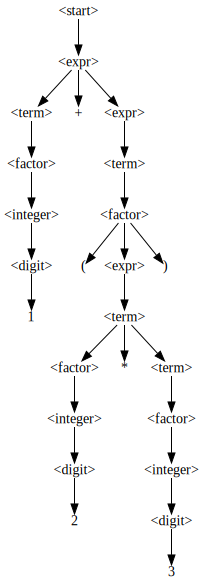

In [25]:
mystring = "1 + (2 * 3)"
peg = PEGParser(EXPR_GRAMMAR)
for tree in peg.parse(mystring):
    assert all_terminals(tree) == mystring
    display_tree(tree)

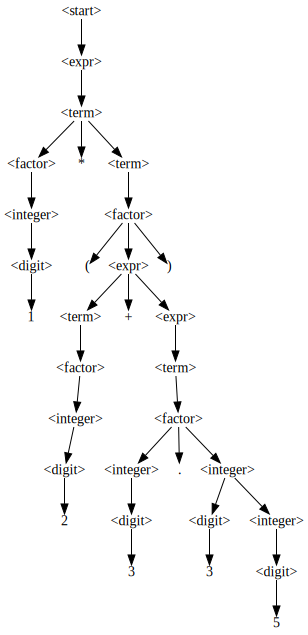

In [26]:
mystring = "1 * (2 + 3.35)"
for tree in peg.parse(mystring):
    assert all_terminals(tree) == mystring
    display_tree(tree)

One should be aware that while the grammar looks like a *CFG*, the language described by a *PEG* may be different. Indeed, only *LL(1)* grammars are guaranteed to represent the same language for both PEGs and other parsers. Behavior of PEGs for other classes of grammars could be surprising~\cite{redziejowski2008}. 

### Recombining Parsed Inputs

Recombining parsed inputs was pioneered by _Langfuzz_ \cite{Holler2012}. The basic idea is that program inputs often carry additional constraints beyond what is described by the syntax. For example, in Java, one needs to declare a variable (using a specific format for declaration) before it can be used in an expression. This restriction is not captured in the _Java CFG_. Checking for type correctness is another example for additional restrictions carried by program definitions.

When fuzzing compilers and interpreters, naive generation of programs using the language *CFG* often fails to achieve significant deeper coverage due to these kinds of checks external to the grammar. Holler et al. suggests using pre-existing valid code fragments to get around these restrictions. The idea is that the pre-existing valid code fragments already conform to the restrictions external to the grammar, and can often provide a means to evade validity checks.

#### A Simple Fuzzer

A simple idea is that one can treat the derivation tree of a preexisting program as the scaffolding, poke holes in it, and patch it with generated inputs from our grammar. Given below is a grammar for a language that allows definition and assignment of variables.

In [27]:
import string
VAR_GRAMMAR = {
    '<start>': ['<statements>'],
    '<statements>': ['<statement>;<statements>', '<statement>'],
    '<statement>': ['<declaration>', '<assignment>'],
    '<declaration>': ['<def> <identifier>'],
    '<assignment>': ['<identifier>=<expr>'],
    '<def>': ['def'],
    '<identifier>': ['<word>'],
    '<word>': ['<alpha><word>', '<alpha>'],
    '<alpha>':
    list(string.ascii_letters),
    '<expr>': ['<term>+<expr>', '<term>-<expr>', '<term>'],
    '<term>': ['<factor>*<term>', '<factor>/<term>', '<factor>'],
    '<factor>':
    ['+<factor>', '-<factor>', '(<expr>)', '<identifier>', '<number>'],
    '<number>': ['<integer>.<integer>', '<integer>'],
    '<integer>': ['<digit><integer>', '<digit>'],
    '<digit>':
    list(string.digits),
}

Let us use our new grammar to parse a program. But before that, given that our grammar is rather detailed, we need to define our token nodes.

In [28]:
VAR_TOKENS = {'<def>', '<number>', '<identifier>'}

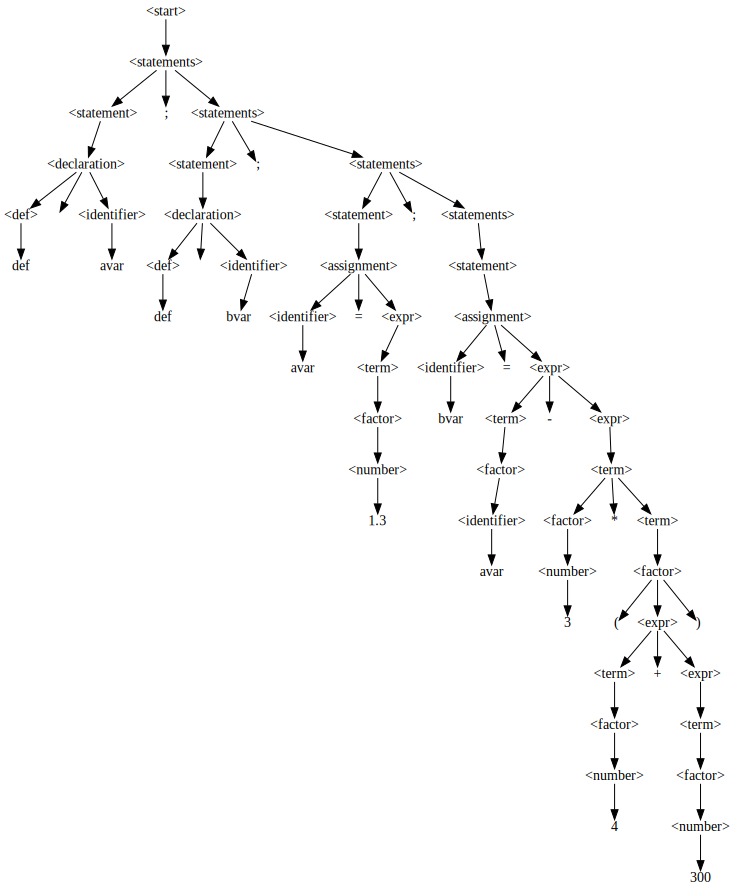

In [29]:
mystring = 'def avar;def bvar;avar=1.3;bvar=avar-3*(4+300)'
parser = PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS)
for tree in parser.parse(mystring):
    display_tree(tree)

We develop a `LangFuzzer` class that generates recombined inputs.

To apply the _Langfuzz_ approach, we need a few parsed strings.

In [30]:
mystrings = [
    'def abc;abc=12+(3+3.3)',
    'def a;def b;def c;a=1;b=2;c=a+b',
    'def avar;def bvar;avar=1.3;bvar=avar-3*(4+300)',
    'def a;def b;a=1.3;b=a-1*(4+3+(2/a))',
    'def a;def b;def c;def d;a=10;b=20;c=34;d=-b+(b*b-4*a*c)/(2*a)',
    'def x;def y;def z;x=10;y=20;z=(x+y)*(x-y)',
    'def x;def y;def z;x=23;y=51;z=x*x-y*y',
]

We recurse through any given tree, collecting parsed fragments corresponding to each nonterminal. Further, we also name each node so that we can address each node separately.

In [31]:
class LangFuzzer(Fuzzer):
    def __init__(self, parser):
        self.parser = parser
        self.fragments = {k: [] for k in self.parser.cgrammar}

    def traverse_tree(self, node):
        counter = 1
        nodes = {}

        def helper(node, id):
            nonlocal counter
            name, children = node
            new_children = []
            nodes[id] = node
            for child in children:
                counter += 1
                new_children.append(helper(child, counter))
            return name, new_children, id

        return helper(node, counter), nodes

    def fragment(self, strings):
        self.trees = []
        for string in strings:
            for tree in self.parser.parse(string):
                tree, nodes = self.traverse_tree(tree)
                self.trees.append((tree, nodes))
                for node in nodes:
                    symbol = nodes[node][0]
                    if symbol in self.fragments:
                        self.fragments[symbol].append(nodes[node])
        return self.fragments

We thus obtain all valid fragments from our parsed strings.

In [32]:
lf = LangFuzzer(PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS))
fragments = lf.fragment(mystrings)
for key in fragments:
    print("%s: %d" % (key, len(fragments[key])))

<start>: 7
<statements>: 36
<statement>: 36
<declaration>: 18
<assignment>: 18
<def>: 18
<identifier>: 55
<word>: 0
<alpha>: 0
<expr>: 39
<term>: 50
<factor>: 51
<number>: 23
<integer>: 0
<digit>: 0


All that remains is to actually find a place to poke a hole using `candidate`, and patch that hole using `generate_new_tree`.

In [33]:
import random


class LangFuzzer(LangFuzzer):
    def __init__(self, parser, strings):
        self.parser = parser
        self.fragments = {k: [] for k in self.parser.cgrammar}
        self.fragment(strings)
    
    def generate_new_tree(self, node, choice):
        name, children, id = node
        if id == choice:
            return random.choice(self.fragments[name])
        else:
            return (name, [self.generate_new_tree(c, choice) for c in children])
        
    def candidate(self):
        tree, nodes = random.choice(self.trees)
        interesting_nodes = [
            n for n in nodes if nodes[n][0] in self.fragments
            and len(self.fragments[nodes[n][0]]) > 1
        ]
        node = random.choice(interesting_nodes)
        return tree, node
    
    def fuzz(self):
        tree, node = self.candidate()
        modified = self.generate_new_tree(tree, node)
        return all_terminals(modified)

Here is our fuzzer in action.

In [34]:
lf = LangFuzzer(PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS), mystrings)
for i in range(100):
    print(lf.fuzz())

d=-b+(b*b-4*a*c)/(2*a);def b;def c;def d;a=10;b=20;c=34;d=-b+(b*b-4*a*c)/(2*a)
def b;def y;def z;x=23;y=51;z=x*x-y*y
def x;def y;def z;x=10;y=20;z=10*(x-y)
def abc;abc=12+(x+3.3)
def x;def y;def z;x=10;y=20;z=(3*(4+300)+y)*(x-y)
def a;def a;def c;def d;a=10;b=20;c=34;d=-b+(b*b-4*a*c)/(2*a)
def a;def b;a=1.3;b=a-1*(4+3+(2/a))
def x;def y;def z;x=10;a=20;z=(x+y)*(x-y)
def avar;def c;avar=1.3;bvar=avar-3*(4+300)
def a;def b;a=1.3;b=a-1*(4+3+a)
def avar;def bvar;avar=1.3;bvar=-b-3*(4+300)
def a;def b;def c;a=1;b=20;c=a+b
z=(x+y)*(x-y);def bvar;avar=1.3;bvar=avar-3*(4+300)
def a;def b;a=(x+y)*(x-y);b=a-1*(4+3+(2/a))
def a;def b;def y;a=1;b=2;c=a+b
def a;def b;def c;def b;a=10;b=20;c=34;d=-b+(b*b-4*a*c)/(2*a)
def a;def y;def c;a=1;b=2;c=a+b
def avar;def bvar;avar=1.3;bvar=avar-3*(b*b+300)
def x;def y;def z;x=12+(3+3.3);y=20;z=(x+y)*(x-y)
def abc;abc=1+(3+3.3)
def a;def b;def c;a=1;b=2;c=a+y
def x;def y;def z;x=20;y=20;z=(x+y)*(x-y)
def a;def b;a=1.3;b=a-1*(4+(2*a)+(2/a))
def avar;def bvar;av

###  Problems with PEG
While _PEGs_ are simple at first sight, their behavior in some cases might be a bit unintuitive. For example, here is an example~\cite{redziejowski}:

In [35]:
PEG_SURPRISE = {
    "<A>": ["a<A>a", "aa"]
}

When interpreted as a *CFG* and used as a string generator, it will produce strings of the form `a, aa, aaaa, aaaaaa` that is, it produces strings where the number of `a` is $2*n$.

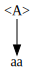

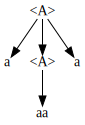

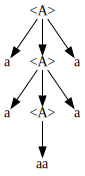

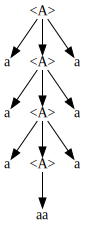

['aa', 'aaaa', 'aaaaaa', 'aaaaaaaa']

In [36]:
strings = []
for e in range(4):
    f = GrammarFuzzer(PEG_SURPRISE, '<A>')
    tree = ('<A>', None)
    for _ in range(e):
        tree = f.expand_tree_once(tree)
    tree = f.expand_tree_with_strategy(tree, f.expand_node_min_cost)
    strings.append(all_terminals(tree))
    display_tree(tree)
strings

However, the _PEG_ parser can only recognize strings of the form $2^n$

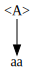

aa


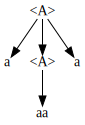

aaaa


Traceback (most recent call last):
  File "<ipython-input-37-dec55ebf796e>", line 4, in <module>
    for tree in peg.parse(s):
  File "<ipython-input-12-7a0a0d883ea8>", line 18, in parse
    raise SyntaxError("at " + repr(text[cursor:]))
  File "<string>", line None
SyntaxError: at 'aa' (expected)


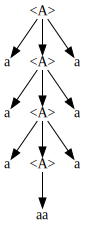

aaaaaaaa


In [37]:
peg = PEGParser(PEG_SURPRISE, start_symbol='<A>')
for s in strings:
    with ExpectError():
        for tree in peg.parse(s):
            display_tree(tree)
        print(s)

We will see how we can overcome these problems with general purpose parsers next.

## Context Free Grammars

While the _Parsing Expression Grammars_ are expressive and the _packrat_ parser for parsing them is simple and intuitive, PEGs suffer from a major deficiency for our purposes. PEGs are oriented towards language recognition, and it is not clear how to translate an arbitrary PEG to a _CFG_. As we mentioned earlier, a naive re-interpretation of a PEG as a CFG does not work very well. Further, it is not clear what is the exact relation between the class of languages represented by _PEG_ and the the class of languages represented by _CFG_. Since our primary focus is _fuzzing_ -- that is _generation_ of strings, we next look at parsers that can accept _CFG_.

The `rules` method takes in a grammar and returns `(key,production)` pairs for each production in the grammar. This is an alternative representation of a grammar.

In [38]:
def rules(grammar):
    return [(key, choice)
            for key, choices in grammar.items()
            for choice in choices]

We require an additional step to massage our `EXPR_GRAMMAR`. Some of the symbols in `EXPR_GRAMMAR` contain extraneous spaces. We need to remove these spaces from the grammar definition. While the spaces are reasonable when one is generating strings, they make our parses needlessly complicated.

In [39]:
EXPR_GRAMMAR_NS = {}
for key, alts in canonical(EXPR_GRAMMAR).items():
    EXPR_GRAMMAR_NS[key] = [''.join(sym.strip() for sym in alt) for alt in alts]

In [40]:
rules(EXPR_GRAMMAR_NS)

[('<start>', '<expr>'),
 ('<expr>', '<term>+<expr>'),
 ('<expr>', '<term>-<expr>'),
 ('<expr>', '<term>'),
 ('<term>', '<factor>*<term>'),
 ('<term>', '<factor>/<term>'),
 ('<term>', '<factor>'),
 ('<factor>', '+<factor>'),
 ('<factor>', '-<factor>'),
 ('<factor>', '(<expr>)'),
 ('<factor>', '<integer>.<integer>'),
 ('<factor>', '<integer>'),
 ('<integer>', '<digit><integer>'),
 ('<integer>', '<digit>'),
 ('<digit>', '0'),
 ('<digit>', '1'),
 ('<digit>', '2'),
 ('<digit>', '3'),
 ('<digit>', '4'),
 ('<digit>', '5'),
 ('<digit>', '6'),
 ('<digit>', '7'),
 ('<digit>', '8'),
 ('<digit>', '9')]

The `terminals` method extracts all terminal symbols from a `canonical` grammar representation.

In [41]:
def terminals(grammar):
    return set(token
               for key, choice in rules(grammar)
               for token in choice if token not in grammar)

In [42]:
terminals(canonical(EXPR_GRAMMAR_NS))

{'(',
 ')',
 '*',
 '+',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9'}

In [43]:
pp_grammar(canonical(EXPR_GRAMMAR_NS))

<start> = <expr>
<expr> = <term> + '+' + <expr>
	| <term> + '-' + <expr>
	| <term>
<term> = <factor> + '*' + <term>
	| <factor> + '/' + <term>
	| <factor>
<factor> = '+' + <factor>
	| '-' + <factor>
	| '(' + <expr> + ')'
	| <integer> + '.' + <integer>
	| <integer>
<integer> = <digit> + <integer>
	| <digit>
<digit> = '0'
	| '1'
	| '2'
	| '3'
	| '4'
	| '5'
	| '6'
	| '7'
	| '8'
	| '9'


There is a choice being made here. As we mentioned before, traditionally, obtaining the derivation tree involved two phases: *lexing* and *parsing*. Lexing involves splitting of incoming input stream into tokens, and is often accomplished with a _Regular Grammar_ or a _Regular Expression_. However, a separate lexing stage is not a requirement because _CFGs_ can be easily extended with the _Regular Grammar_ one uses for lexing, and both lexing and parsing can be accomplished in one stage.

### Earley Parser

The Earley parser is a general parser that is able to parse any arbitrary *CFG*. It was invented by Jay Earley~\cite{Earley1970} for use in computational linguistics. While its computational complexity is $O(n^3)$ for parsing strings with arbitrary grammars, it can parse strings with unambiguous grammars in $O(n^2)$ time, and all *[LR(k)](https://en.wikipedia.org/wiki/LR_parser)* grammars in linear time ($O(n)$~\cite{Leo1991}). Further improvements -- notably handling epsilon rules -- were invented by Aycock et al.~\cite{Aycock2002}.

Note that one restriction of our implementation is that the start symbol should have only one alternative in its alternative expressions. This is not a restriction in practice because any grammar with multiple alternatives for its start symbol can be extended with a new start symbol that has the original start symbol as its only choice. That is, given a grammar as below,

```
grammar = {
    '<start>': ['<A>', '<B>'],
    '<A>': ['a'],
    '<B>': ['b'],    
}
```
One may rewrite it as below to conform to the *single-alternative* rule.
```
grammar = {
    '<start>': ['<start_>'],
    '<start_>': ['<A>', '<B>'],
    '<A>': ['a'],
    '<B>': ['b'],    
}
```

We first implement a simpler parser that is a parser for nearly all *CFGs*, but not quite. In particular, our parser does not understand *Epsilon* rules -- rules that derive empty string. We show later how the parser can be extended to handle these.

The parser uses dynamic programming to generate a table containing a forest of possible parses at each letter index -- the table contains as many columns as there are letters in the input, and each column contains different parsing rules at various stages of the parse.


#### Columns
We define the `Column` first. The `Column` is initialized by its own `index` in the input string, and the `letter` at that index. Internally, we also keep track of the states that are added to the column as the parsing progresses.

In [44]:
class Column(object):
    def __init__(self, index, letter):
        self.index, self.letter = index, letter
        self.states, self._unique = [], {}

    def __str__(self):
        return "%s chart[%d]\n%s" % (self.letter, self.index, "\n".join(
            str(state) for state in self.states if state.finished()))

The `Column` only stores unique `states`. Hence, when a new `state` is `added` to our `Column`, we check whether it is already known.

In [45]:
class Column(Column):
    def add(self, state):
        if state in self._unique:
            return self._unique[state]
        self._unique[state] = state
        self.states.append(state)
        state.e_col = self
        return self._unique[state]

#### Item
An item represents a parse in progress for a specific rule. Hence the item contains the name of the nonterminal, and the corresponding alternative expression (`expr`) which together form the rule, and the current position of parsing in this expression -- `dot`.


**Note.** If you are familiar with [LR parsing](https://en.wikipedia.org/wiki/LR_parser), you will notice that an item is simply an `LR0` item.

In [46]:
class Item(object):
    def __init__(self, name, expr, dot):
        self.name, self.expr, self.dot = name, expr, dot

We also provide a few convenience methods. The method `finished()` checks if the `dot` has moved beyond the last element in `expr`. The method `advance()` produces a new `Item` with the `dot` advanced one token, and represents an advance of the parsing.  The method `at_dot()` returns the current symbol being parsed.

In [47]:
class Item(Item):
    def finished(self):
        return self.dot >= len(self.expr)

    def advance(self):
        return Item(self.name, self.expr, self.dot + 1)

    def at_dot(self):
        return self.expr[self.dot] if self.dot < len(self.expr) else None

#### States

For `Earley` parsing, the state of the parsing is simply one `Item` along with some meta information such as the starting `s_col`  and ending column `e_col` for each state. Hence we inherit from `Item` to create a `State`.
We also store a reference to all the child states (that is, all states that originates from nonterminals in the `expr`). Since we are interested in comparing states, we define `hash()` and `eq()` with the corresponding methods.

In [48]:
class State(Item):
    def __init__(self, name, expr, dot, s_col):
        super().__init__(name, expr, dot)
        self.s_col, self.e_col = s_col, None

    def __str__(self):
        return self.name + ':= ' + ' '.join([
            str(p)
            for p in [*self.expr[:self.dot], '|', *self.expr[self.dot:]]
        ]) + "(%d,%d)" % (self.s_col.index, self.e_col.index)

    def _t(self):
        return (self.name, self.expr, self.dot, self.s_col.index)

    def __hash__(self):
        return hash(self._t())

    def __eq__(self, other):
        return self._t() == other._t()

    def advance(self):
        return State(self.name, self.expr, self.dot + 1, self.s_col)

#### The Parser

We use the following grammar in our examples below.
```
grammar = {
    '<start>': ['<A><B>'],
    '<A>': ['a<B>c', 'A<A>'],
    '<B>': ['b<C>', '<D>'],
    '<C>': ['c'],
    '<D>': ['d']
}
```

The _Earley_ algorithm starts by initializing the chart with columns (as many as there are letters in the input). We also seed the first column with a state representing the expression corresponding to the start symbol. In our case, the state corresponds to the start symbol with the `dot` at `0` is represented as below. The `●` symbol represents the parsing status. In this case, we have not parsed anything.

```
<start>: ● <A> <B>
```
We pass this partial chart to a method for filling the rest of the parse chart.

We call it the `EarleyParser` because it is not yet an `Earley` parser (because we went with the simplistic tracking of children).

In [49]:
class EarleyParser(Parser):
    def __init__(self, grammar, **kwargs):
        super().__init__(grammar, **kwargs)
        self.cgrammar = canonical(grammar, letters=True)

Before starting to parse, we seed the chart with the state representing the ongoing parse of the start symbol.

In [50]:
class EarleyParser(EarleyParser):
    def chart_parse(self, words, start):
        alt = tuple(*self.cgrammar[start])
        chart = [Column(i, tok) for i, tok in enumerate([None, *words])]
        chart[0].add(State(start, alt, 0, chart[0]))
        return self.fill_chart(chart)

The main loop has three fundamental operations. `predict`, `scan`, and `complete`. We discuss `predict` next.

##### Predict
We have already seeded `chart[0]` with a state `[<A>,<B>]` with `dot` at `0`. Next, given that `<A>` is a nonterminal, we `predict` the possible parse continuations of this state. That is, it could be either `a <B> c` or `A <A>`.

The general idea of `predict()` is as follows: Say you have a state with name `<A>` from the above grammar, and expression containing `[a,<B>,c]`. Imagine that you have seen `a` already, which means that the `dot` will be on `<B>`. Below, is a representation of our parse status. The left hand side of ● represents the portion already parsed (`a`), and the right hand side represents the portion yet to be parsed (`<B> c`).

```
<A>: a  ●  <B> c
```

To recognize `<B>`, we look at the definition of `<B>`, which has different alternative expressions. The `predict` step adds each of these alternatives to the set of states, with `dot` at `0`.

```
<A>: a ● <B> c
<B>: ● b c
<B>: ● <D>
```

In essence, the `predict()` method, when called with the current nonterminal, fetches the alternative expressions corresponding to this nonterminal, and adds these as predicted _child_ states to the _current_ column.

In [51]:
class EarleyParser(EarleyParser):
    def predict(self, col, sym, state):
        for alt in self.cgrammar[sym]:
            col.add(State(sym, tuple(alt), 0, col))

##### Scan
What if rather than a nonterminal, the state contained a terminal symbol -- i.e a letter? In that case, we are ready to make some progress. For example, consider the second state:
```
<B>: ● b c
```
We `scan` the next column's letter. Say the next token is `b`.
If the letter matches what we have, then create a new state by advancing the current state by one letter.

```
<B>: b ● c
```
This new state is added to the next column (i.e the column that has the matched letter).

In [52]:
class EarleyParser(EarleyParser):
    def scan(self, col, state, letter):
        if letter == col.letter:
            col.add(state.advance())

##### Complete

When we advance, what if we actually `complete` the processing of the current rule? If so, we want to update not just this state, but also all the _parent_ states from which this state was derived.
For example, say we have states as below.
```
<A>: a ● <B> c
<B>: b c ● 
```
The state `<B>: b c ●` is now complete. So, we need to advance `<A>: a ● <B> c` one step forward.

How do we determine the parent states? Note from `predict` that we added the predicted child states to the _same_ column as that of the inspected state. Hence, we look at the starting column of the current state, with the same symbol `at_dot` as that of the name of the completed state.

For each such parent found, we advance that parent (because we have just finished parsing that non terminal for their `at_dot`) and add the new states to the current column.

In [53]:
class EarleyParser(EarleyParser):
    def complete(self, col, state):
        return self.earley_complete(col, state)

    def earley_complete(self, col, state):
        parent_states = [
            st for st in state.s_col.states if st.at_dot() == state.name
        ]
        for st in parent_states:
            col.add(st.advance())

##### Fill chart
The main driving loop in `fill_chart` essentially calls these operations in order. We loop over each column in order. For each column, fetch one state in the column at a time, and check if the state is `finished`. If it is, then we `complete` all the parent states depending on this state. If the state was not finished, we check to see if the state's current symbol `at_dot` is a nonterminal. If it is a nonterminal, we `predict` possible continuations, and update the current column with these states. If it was not, we `scan` the next column and advance the current state if it matches the next letter.

In [54]:
class EarleyParser(EarleyParser):
    def fill_chart(self, chart):
        for i, col in enumerate(chart):
            for state in col.states:
                if state.finished():
                    self.complete(col, state)
                else:
                    sym = state.at_dot()
                    if sym in self.cgrammar:
                        self.predict(col, sym, state)
                    else:
                        if i + 1 >= len(chart):
                            continue
                        self.scan(chart[i + 1], state, sym)
            if self.log:
                print(col)
        return chart

Since `chart_parse` returns the completed table, we now need to extract the derivation trees.

##### Parse

For determining how far we have managed to parse, we simply look for the last index from `chart_parse` where the `start_symbol` was found.

In [55]:
class EarleyParser(EarleyParser):
    def parse_prefix(self, text):
        table = self.chart_parse(text, self.start_symbol)
        for col in reversed(table):
            states = [st for st in col.states if st.name == self.start_symbol]
            if states:
                return col.index, states
        return -1, []

The following is adapted from the excellent reference on Earley parsing by [Loup Vaillant](http://loup-vaillant.fr/tutorials/earley-parsing/).

The `parse` procedure has to construct the parsed forest. Our chart is a table of states that contains production rules that end at that index. For easier parsing, we switch to a table that contains rules that begin at that index.

In [56]:
class EarleyParser(EarleyParser):
    def reverse(self, table):
        f_table = [Column(c.index, c.letter) for c in table]
        for col in table:
            finished = [s for s in col.states if s.finished()]
            for s in finished:
                f_table[s.s_col.index].states.append(s)
        return f_table

We use the previously defined `reverse` to parse and extract the parse forest. We need to extract the parse forest from the chart as we show in the next section.

In [57]:
class EarleyParser(EarleyParser):
    def parse(self, text):
        cursor, states = self.parse_prefix(text)
        if cursor != len(text):
            return []
        table = self.chart_parse(text, self.start_symbol)
        f_table = self.reverse(table)
        start = next(s for s in states if s.finished())
        return self.extract_trees(self.parse_forest(f_table, start))

##### Parse Forests

The `parse_forest` takes the state which represents the completed parse, and determines the possible ways that its expressions corresponded to the parsed expression. For example, say we are parsing `1+2+3`, and the state has `[<expr>,+,<expr>]` in `expr`. It could have been parsed as either `[{<expr>:1+2},+,{<expr>:3}]` or `[{<expr>:1},+,{<expr>:2+3}]`.

In [58]:
class EarleyParser(EarleyParser):
    def parse_forest(self, chart, state):
        if not state.expr:
            return (state.name, [])
        pathexprs = self.parse_paths(state.expr, chart, state.s_col.index,
                                     state.e_col.index)
        paths_ = []
        for pathexpr in pathexprs:
            pathexpr_ = []
            for varexpr in pathexpr:
                completion = (self.parse_forest(chart, varexpr) if isinstance(
                    varexpr, State) else (varexpr, []))
                pathexpr_.append(completion)
            paths_.append(pathexpr_)
        return (state.name, paths_)

##### Parse Paths

The `parse_paths` method tries to unify the given expression in `named_expr` with the parsed string. For that, it extracts the first symbol in `named_expr` and checks if it is a terminal symbol. If it is, then it checks the chart to see if the letter corresponding to the position matches the terminal symbol. If it does, advance our start index by the length of the symbol.

If the symbol was a nonterminal symbol, then we retrieve the parsed states at the current start index that correspond to the nonterminal symbol, and collect the end index. These are the start indexes for the remaining expression.

Given our list of start indexes, we obtain the parse paths from the remaining expression. If we can obtain any, then we return the parse paths. If not, we return an empty list.

In [59]:
class EarleyParser(EarleyParser):
    def parse_paths(self, named_expr, chart, frm, til):
        var, *expr = named_expr
        starts = None
        if var not in self.cgrammar:
            starts = ([(var, frm + len(var))]
                      if frm < til and chart[frm + 1].letter == var else [])
        else:
            starts = [(s, s.e_col.index) for s in chart[frm].states
                      if s.name == var]

        paths = []
        for state, start in starts:
            if not expr:
                paths.extend([[state]] if start == til else [])
            else:
                res = self.parse_paths(expr, chart, start, til)
                paths.extend([[state] + r for r in res])
        return paths

##### extract_a_tree

What we have from `parse_forest` is a forest of trees. We need to extract a single tree from that forest. That is accomplished as follows.

(For now, we return the first available derivation tree. To do that, we need to extract the parse forest from the state corresponding to `start`.)

In [60]:
class EarleyParser(EarleyParser):
    def extract_a_tree(self, forest_node):
        name, paths = forest_node
        if not paths:
            return (name, [])
        return (name, [self.extract_a_tree(p) for p in paths[0]])

    def extract_trees(self, forest):
        return [self.extract_a_tree(forest)]

We now verify that our modifications work.

In [61]:
A3_GRAMMAR = {
    "<start>": ["<expr>"],
    "<expr>": ["<expr>+<expr>", "<expr>-<expr>", "(<expr>)", "<integer>"],
    "<integer>": ["<digit><integer>", "<digit>"],
    "<digit>": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

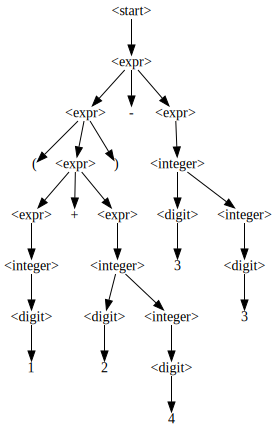

In [62]:
mystring = '(1+24)-33'
parser = EarleyParser(A3_GRAMMAR)
for tree in parser.parse(mystring):
    assert all_terminals(tree) == mystring
    display_tree(tree)

#### Ambiguous parsing

Ambiguous grammars are grammars that can produce multiple derivation trees for some given string. For example, the `A3_GRAMMAR` can parse `1+2+3` in two different ways -- `[1+2]+3` and `1+[2+3]`. We see how to fix it next.

##### extract_trees

Extracting a single tree might be reasonable for unambiguous parses. However, what if the given grammar produces ambiguity when given a string? We need to extract all derivation trees in that case. We enhance our `extract_trees` to extract multiple derivation trees.

In [63]:
class EarleyParser(EarleyParser):
    def extract_trees(self, forest_node):
        name, paths = forest_node
        if not paths:
            return [(name, [])]
        results = []
        for path in paths:
            ptrees = zip(*[self.extract_trees(p) for p in path])
            results.extend([(name, p) for p in ptrees])
        return results

As before, we verify that everything works.

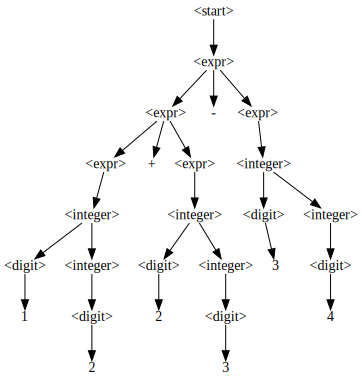

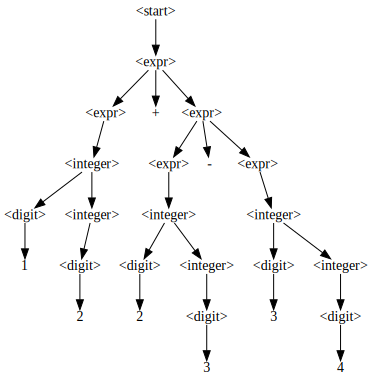

In [64]:
mystring = '12+23-34'
parser = EarleyParser(A1_GRAMMAR)
for tree in parser.parse(mystring):
    assert mystring == all_terminals(tree)
    display_tree(tree)

One can also use a `GrammarFuzzer` to verify that everything works.

In [65]:
gf = GrammarFuzzer(A1_GRAMMAR)
for i in range(5):
    s = gf.fuzz()
    print(i, s)
    for tree in parser.parse(s):
        assert all_terminals(tree, A1_GRAMMAR) == s

0 433898
1 18
2 9+2282+2
3 9-1+0-0+4-1-3+9+9-5+37
4 1-6+5-0+6+1-1-240+9-3-5


#### The Aycock Epsilon fix

While parsing, one often requires to know whether a given nonterminal can derive an empty string. For example, in the following grammar A can derive an empty string, while B can't. The nonterminals that can derive an empty string are called _nullable_ nonterminals. For example, in the below grammar `E_GRAMMAR_1`,  `<A>` is _nullable_, and since `<A>` is one of the alternatives of `<start>`, `<start>` is also _nullable_. But `<B>` is not _nullable_.

In [66]:
E_GRAMMAR_1 = {
    '<start>': ['<A>', '<B>'],
    '<A>': ['a', ''],
    '<B>': ['b']
}

One of the problems with the original Earley implementation is that it does not handle rules that can derive empty strings very well. For example, the given grammar should match `a`

In [67]:
EPSILON = ''
E_GRAMMAR = {
        '<start>': ['<S>'],
        '<S>': ['<A><A><A><A>'],
        '<A>': ['a', '<E>'],
        '<E>': [EPSILON]
}

In [68]:
mystring = 'a'
parser = EarleyParser(E_GRAMMAR)
trees = parser.parse(mystring)
print(trees)

[]


Aycock et al. suggests a simple fix. Their idea is to pre-compute the `nullable` set and use it to advance the `nullable` states. However, before we do that, we need to compute the `nullable` set. The `nullable` set consists of all nonterminals that can derive an empty string.

Computing the `nullable` set requires expanding each production rule in the grammar iteratively and inspecting whether a given rule can derive the empty string. Each iteration needs to take into account new terminals that have been found to be `nullable`. The procedure stops when we obtain a stable result. This procedure can be abstracted into a more general method `fixpoint`.

##### Fixpoint

A `fixpoint` of a function is an element in the function's domain such that it is mapped to itself. For example, 1 is a `fixpoint` of square root because `squareroot(1) == 1`.

(We use `str` rather than `hash` to check for equality in `fixpoint` because the data structure `set`, which we would like to use as an argument has a good string representation but is not hashable).

In [69]:
def fixpoint(f):
    def helper(arg):
        while True:
            sarg = str(arg)
            arg_ = f(arg)
            if str(arg_) == sarg:
                return arg
            arg = arg_

    return helper

Remember `my_sqrt` from the first chapter? We can define my_sqrt using fixpoint.

In [70]:
def my_sqrt(x):
    @fixpoint
    def _my_sqrt(approx):
        return (approx + x / approx) / 2

    return _my_sqrt(1)

In [71]:
my_sqrt(2)

1.414213562373095

##### Nullable

Similarly, we can define `nullable` using `fixpoint`. We essentially provide the definition of a single intermediate step. That is, assuming that `nullables` contain the current `nullable` nonterminals, we iterate over the grammar looking for productions which are `nullable` -- that is, productions where the entire sequence can yield an empty string on some expansion.

In [72]:
def nullable_expr(expr, nullables):
    return all(token in nullables for token in expr)


def nullable(grammar):
    productions = rules(grammar)

    @fixpoint
    def nullable_(nullables):
        for A, expr in productions:
            if nullable_expr(expr, nullables):
                nullables |= {A}
        return (nullables)

    return nullable_({EPSILON})

In [73]:
for key, grammar in {
        'E_GRAMMAR': E_GRAMMAR,
        'E_GRAMMAR_1': E_GRAMMAR_1
}.items():
    print(key, nullable(canonical(grammar)))

E_GRAMMAR {'', '<start>', '<E>', '<A>', '<S>'}
E_GRAMMAR_1 {'', '<A>', '<start>'}


So, once we have the `nullable` set, all that we need to do is, after we have called `predict` on a state corresponding to a nonterminal, check if it is `nullable` and if it is, advance and add the state to the current column.

In [74]:
class EarleyParser(EarleyParser):
    def __init__(self, grammar, **kwargs):
        super().__init__(grammar, **kwargs)
        self.cgrammar = canonical(grammar, letters=True)
        self.epsilon = nullable(self.cgrammar)

    def predict(self, col, sym, state):
        for alt in self.cgrammar[sym]:
            col.add(State(sym, tuple(alt), 0, col))
        if sym in self.epsilon:
            col.add(state.advance())

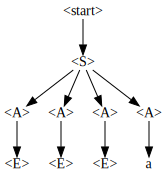

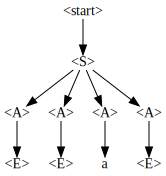

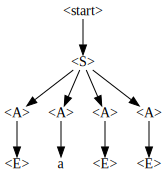

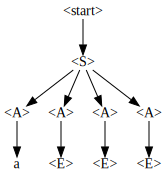

In [75]:
mystring = 'a'
parser = EarleyParser(E_GRAMMAR)
for tree in parser.parse(mystring):
    display_tree(tree)

#### More Earley parsing
A number of other optimizations exist for Earley parsers. A fast industrial strength Earley parser implementation is the [Marpa parser](https://jeffreykegler.github.io/Marpa-web-site/). Further, Earley parsing need not be restricted to character data. One may also parse streams (audio and video streams)~\cite{qi2018generalized} using a generalized Earley parser.

## Testing the parsers

While we have defined two parser variants, it would be nice to have some confirmation that our parses work well. While it is possible to formally prove that they work, it is much more satisfying to generate random grammars, their corresponding strings, and parse them using the same grammar.

In [76]:
def prod_line_grammar(nt, t):
    g = {
        '<start>': ['<SYMBOLS>'],
        '<SYMBOLS>': ['<SYMBOL><SYMBOLS>', '<SYMBOL>'],
        '<SYMBOL>': ['<NT>', '<T>'],
        '<NT>': ['<NT_><ALPHA><_NT>'],
        '<NT_>': ['<'],
        '<_NT>': ['>'],
        '<ALPHA>': nt,
        '<T>': t
    }
    if not nt:
        g['<NT>'] = ['']
    return g


def make_alt(nt, t, num_alts):
    prod_grammar = prod_line_grammar(nt, t)
    gf = GrammarFuzzer(prod_grammar, min_nonterminals=3, max_nonterminals=5)
    name = "<%s>" % ''.join(random.choices(string.ascii_uppercase, k=3))
    return (name, [gf.fuzz() for _ in range(num_alts)])

def make_grammar():
    a = list(string.ascii_lowercase)
    grammar = {}
    name = None
    for _ in range(2):
        name, rules = make_alt([k[1:-1] for k in grammar.keys()], a, 3)
        grammar[name] = rules
    grammar[START_SYMBOL] = [name]
    return grammar

Now we verify if our arbitrary grammars can be used by the Earley parser.

<ZZG> = 
	| 'i'
	| 'kr'
<LRE> = <ZZG> + 'vf'
	| <ZZG> + 'be'
	| <ZZG> + 'ia'
<start> = <LRE>
iia


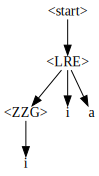

<XVO> = 'ujz'
	| 'wmn'
	| 's'
<JEL> = <XVO> + <XVO> + 'b'
	| <XVO> + <XVO>
	| <XVO> + <XVO>
<start> = <JEL>
ujzs


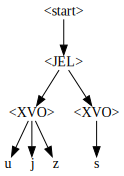

<CJR> = 'pe'
	| 'fwr'
	| 'joi'
<LBF> = <CJR> + 'km'
	| <CJR> + <CJR> + 'e'
	| <CJR> + <CJR>
<start> = <LBF>
pejoie


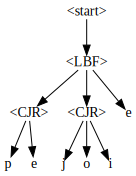

<LKS> = 'k'
	| 'd'
	| 'n'
<YCG> = <LKS> + 'dh'
	| <LKS> + <LKS> + 'm'
	| 'i' + <LKS> + 'q'
<start> = <YCG>
inq


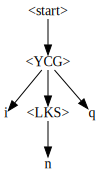

<CEC> = 'os'
	| 'fitrp'
	| 'wc'
<RIX> = <CEC> + 'h' + <CEC> + 'c'
	| 'z' + <CEC> + <CEC> + 'c'
	| <CEC> + 'kq'
<start> = <RIX>
oskq


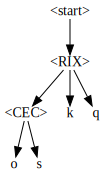

In [77]:
for i in range(5):
    my_grammar = make_grammar()
    pp_grammar(canonical(my_grammar))
    parser = EarleyParser(my_grammar)
    mygf = GrammarFuzzer(my_grammar)
    s = mygf.fuzz()
    print(s)
    for tree in parser.parse(s):
        assert all_terminals(tree) == s
        display_tree(tree)

## Further Information
* *LL* and *LR* are the main traditions in parsing, where *LL* (left-to-right, leftmost derivation) represents a top-down approach, and LR (left-to-right, rightmost derivation) represents a bottom up approach (another way to look at it is that LL parsers compute the derivation tree incrementally in pre-order while LR parsers compute the derivation tree in post-order~\cite{pingali2015graphical}). A grammar is LL(k) if it can be parsed by an LL parser with k lookahead tokens. Similarly LR(k) corresponds to an LR parser with k lookahead tokens. LL(*) (used by ANTLR) on the other hand is a grammar representation that uses *Regular Expression* like predicates (similar to advanced PEGs -- see Exercise 7.3) rather than a fixed lookahead. Both LL(k) and LR(k) grammars have $O(n)$ parsers.
* Pingali et al.~\cite{pingali2015graphical} presents a unified parsing theory that unites LL and LR parsing. They show that LL and LR parsers can be considered optimizations of Earley parsing.
* In terms of representable languages, LL(k) $\subset$ LL(k+1) and LL(k) $\subset$ LR(1). All deterministic *CFLs* have an LR(1) grammar.
* There exist *CFLs* with strings that can not be unambiguously parsed (called *inherently ambiguous languages*) ~\cite{ogden1968helpful}. Hence, there exist CFL for which one can't provide an LR grammar.
* The other main parsing algorithms for CFG are GLL~\cite{scott2010gll}, GLR~\cite{tomita1987efficient,tomita2012generalized}, and CYK~\cite{grune1990parsing}.
* Parsing with arbitrary *CFG* is reducible to boolean matrix multiplication~\cite{Valiant1975} (and the reverse~\cite{Lee2002}) which is at present bounded by $O(2^{23728639}$) ~\cite{LeGall2014}.
* The basic technique for implementing *CFL* parsers was provided by Bar-Hillel et al.~\cite{bar1961formal} in 1964 who showed that the intersection between a *CFL* and a *Regular Language* is still a *CFL* using a constructivist proof that generated the grammar for the new language. Given that a string to be parsed is a trivial *Regular Expression* with no meta characters, the *intersection grammar* between the given *CFG* and the string (the trivial *Regular Language*) is the parse forest which encodes all possible parses of that string. This parse forest representation is used by all main *CFL* parsing families.
* The actual class of languages that is expressible in *PEG* is currently unknown. In particular, we know that *PEGs* can express certain languages such as $a^n b^n c^n$. However, we do not know if there exist *CFLs* that are not expressible with *PEGs*.
* In Section 2.3, we provided an instance of a counter-intuitive PEG grammar. While important for our purposes (we use grammars for generation of inputs) this is not a criticism of parsing with PEGs. PEG focuses on writing grammars for a language, and not necessarily in interpreting what language an arbitrary PEG might yield. Given a Context-Free Language to parse, it is almost always possible to write a grammar for it in PEG, and given that 1) a PEG can parse any string in $O(n)$ time, and 2) at present we know of no CFL that can't be expressed as a PEG, and 3) compared with *LR* grammars, a PEG is often more intuitive because it allows top-down interpretation, when writing a parser for a language, PEGs should be under serious consideration.

## Lessons Learned

* Grammars can be used to generate derivation trees for a given string.
* Parsing Expression Grammars are intuitive, and easy to implement, but require care to write.
* Earley Parsers can parse arbitrary Context Free Grammars.
* How to generate a pool of fragments using the Langfuzz approach, and use it to generate nearly valid strings.

## Next Steps

* [Use the automatic grammar miner for obtaining grammar](GrammarMiner.ipynb)

## Exercises

### Exercise 1 An alternative _Packrat_


In the _Packrat_ parser, we showed how one could implement a simple _PEG_ parser. That parser kept track of the current location in the text using an index. Can you modify the parser so that it simply uses the current substring rather than tracking the index? That is, it should no longer have the `at` parameter.

In [78]:
class PackratParser(Parser):
    def parse_prefix(self, text):
        txt, res = self.unify_key(self.start_symbol, text)
        return len(txt), [res]

    def parse(self, text):
        remain, res = self.parse_prefix(text)
        if remain:
            raise SyntaxError("at " + res)
        return res

    def unify_rule(self, rule, text):
        results = []
        for token in rule:
            text, res = self.unify_key(token, text)
            if res is None:
                return text, None
            results.append(res)
        return text, results

    def unify_key(self, key, text):
        if key not in self.cgrammar:
            if text.startswith(key):
                return text[len(key):], (key, [])
            else:
                return text, None
        for rule in self.cgrammar[key]:
            text_, res = self.unify_rule(rule, text)
            if res:
                return (text_, (key, res))
        return text, None

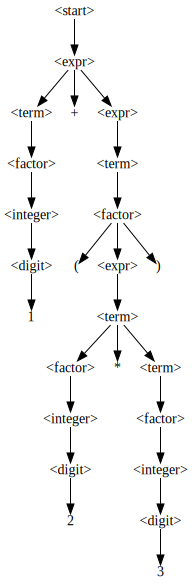

In [79]:
mystring = "1+(2*3)"
for tree in PackratParser(EXPR_GRAMMAR_NS).parse(mystring):
    assert all_terminals(tree) == mystring
    display_tree(tree)

### Exercise 2 _More PEG Syntax_

The _PEG_ syntax provides a few notational conveniences reminiscent of regular expressions. For example, it supports the following operators (letters `T` and `A` represents tokens that can be either terminal or nonterminal. `ε` is an empty string, and `/` is the ordered choice operator similar to the non-ordered choice operator `|`):

* `T?` represents an optional greedy match of T and `A := T?` is equivalent to `A := T/ε`.
* `T*` represents zero or more greedy matches of `T` and `A := T*` is equivalent to `A := T A/ε`.
* `T+` represents one or more greedy matches -- equivalent to `TT*`

If you look at the three notations above, each can be represented in the grammar in terms of basic syntax.
Remember the exercise from [the chapter on grammars](Grammars.ipynb) that developed `define_ex_grammar` that can represent grammars as Python code? extend `define_ex_grammar` to `define_peg` to support the above notational conveniences. The decorator should rewrite a given grammar that contain these notations to an equivalent grammar in basic syntax.

### Exercise 3 _PEG Predicates_

Beyond these notational conveniences, it also supports two predicates that can provide a powerful lookahead facility that does not consume any input.

* `T&A` represents an _And-predicate_ that matches `T` if `T` is matched, and it is immediately followed by `A`
* `T!A` represents a _Not-predicate_ that matches `T` if `T` is matched, and it is *not* immediately followed by `A`

Implement these predicates in our _PEG_ parser.

### Exercise 4 _Earley Fill Chart_

In the `Earley Parser`, `Column` class, we keep the states both as a `list` and also as a `dict` even though `dict` is ordered. Can you explain why?

**Hint**: see the `fill_chart` method.

Python allows us to append to a list in flight, while a dict, eventhough it is ordered does not allow that facility.

That is, the following will work

```python
values = [1]
for v in values:
   values.append(v*2)
```

However, the following will result in an error
```python
values = {1:1}
for v in values:
    values[v*2] = v*2
```

In the `fill_chart`, we make use of this facility to modify the set of states we are iterating on, on the fly.

### Exercise 5 _Leo Parser_

One of the problems with the original Earley parser is that while it can parse strings using arbitrary _Context Free Gramamrs_, its performance on right-recursive grammars is quadratic. That is, it takes $O(n^2)$ runtime and space for parsing with right-recursive grammars. For example, consider these grammars:

In [80]:
LR_GRAMMAR = {
    '<start>': ['<A>'],
    '<A>': ['<A>a', ''],
}

RR_GRAMMAR = {
    '<start>': ['<A>'],
    '<A>': ['a<A>', ''],
}

We enable logging to see the parse progress

In [81]:
mystring = 'aaaaaa'
result = EarleyParser(LR_GRAMMAR, log=True).parse(mystring)

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0)
a chart[1]
<A>:= <A> a |(0,1)
<start>:= <A> |(0,1)
a chart[2]
<A>:= <A> a |(0,2)
<start>:= <A> |(0,2)
a chart[3]
<A>:= <A> a |(0,3)
<start>:= <A> |(0,3)
a chart[4]
<A>:= <A> a |(0,4)
<start>:= <A> |(0,4)
a chart[5]
<A>:= <A> a |(0,5)
<start>:= <A> |(0,5)
a chart[6]
<A>:= <A> a |(0,6)
<start>:= <A> |(0,6)
None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0)
a chart[1]
<A>:= <A> a |(0,1)
<start>:= <A> |(0,1)
a chart[2]
<A>:= <A> a |(0,2)
<start>:= <A> |(0,2)
a chart[3]
<A>:= <A> a |(0,3)
<start>:= <A> |(0,3)
a chart[4]
<A>:= <A> a |(0,4)
<start>:= <A> |(0,4)
a chart[5]
<A>:= <A> a |(0,5)
<start>:= <A> |(0,5)
a chart[6]
<A>:= <A> a |(0,6)
<start>:= <A> |(0,6)


In [82]:
result = EarleyParser(RR_GRAMMAR, log=True).parse(mystring)

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0)
a chart[1]
<A>:= |(1,1)
<A>:= a <A> |(0,1)
<start>:= <A> |(0,1)
a chart[2]
<A>:= |(2,2)
<A>:= a <A> |(1,2)
<A>:= a <A> |(0,2)
<start>:= <A> |(0,2)
a chart[3]
<A>:= |(3,3)
<A>:= a <A> |(2,3)
<A>:= a <A> |(1,3)
<A>:= a <A> |(0,3)
<start>:= <A> |(0,3)
a chart[4]
<A>:= |(4,4)
<A>:= a <A> |(3,4)
<A>:= a <A> |(2,4)
<A>:= a <A> |(1,4)
<A>:= a <A> |(0,4)
<start>:= <A> |(0,4)
a chart[5]
<A>:= |(5,5)
<A>:= a <A> |(4,5)
<A>:= a <A> |(3,5)
<A>:= a <A> |(2,5)
<A>:= a <A> |(1,5)
<A>:= a <A> |(0,5)
<start>:= <A> |(0,5)
a chart[6]
<A>:= |(6,6)
<A>:= a <A> |(5,6)
<A>:= a <A> |(4,6)
<A>:= a <A> |(3,6)
<A>:= a <A> |(2,6)
<A>:= a <A> |(1,6)
<A>:= a <A> |(0,6)
<start>:= <A> |(0,6)
None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0)
a chart[1]
<A>:= |(1,1)
<A>:= a <A> |(0,1)
<start>:= <A> |(0,1)
a chart[2]
<A>:= |(2,2)
<A>:= a <A> |(1,2)
<A>:= a <A> |(0,2)
<start>:= <A> |(0,2)
a chart[3]
<A>:= |(3,3)
<A>:= a <A> |(2,3)
<A>:= a <A> |(1,3)
<A>:= a <A> |(0,3)
<start>

As can be seen from the parsing log for each letter, the number of states with representation `<A>:= a <A> | (i, j)` increases at each stage, and these are simply a left over from the previous letter. They do not contribute anything more to the parse other than to simply complete these entries. However, they take up space, and require resources for inspection, contributing a factor of `n` in analysis.

Joop Leo~\cite{Leo1991} found that this inefficiency can be avoided by detecting right recursion. The idea is that before starting the `completion` step, check whether the current item has a _deterministic reduction path_. If such a path exists, add a copy of the topmost element of the _deteministic reduction path_ to the current column, and return. If not, perform the original `completion` step.

Finding a _deterministic reduction path_ is as follows:

Given a complete state, represented by `<A> := ... | (i)` where `(i)` is the starting column, there is a _deterministic reduction path_ above it if two criteria are satisfied.
* There exist an item `<B> := ... <A> | (k)` in the current column.
* It should have a _single_ predecessor of the form `<B> := ... | <A> (k)` in the current column.
Following this chain (looking for the link above `<B> := ... <A> | (k)`), the topmost item is the item that does not have a parent.

See [Loup Vaillant](http://loup-vaillant.fr/tutorials/earley-parsing/right-recursion) for further information.

In [83]:
class State(State):
    def __init__(self, name, expr, dot, s_col, tag=None):
        super().__init__(name, expr, dot, s_col)
        self.tag = tag

    def copy(self, tag=None):
        return State(self.name, self.expr, self.dot, self.s_col, tag)

    def __str__(self):
        init = "%s %s" % (self.tag or "   ", self.name)
        return init + ':= ' + ' '.join([
            str(p)
            for p in [*self.expr[:self.dot], '|', *self.expr[self.dot:]]
        ]) + "(%d,%d)" % (self.s_col.index, self.e_col.index)


class LeoParser(EarleyParser):
    def complete(self, col, state):
        return self.leo_complete(col, state)

    def leo_complete(self, col, state):
        detred = self.deterministic_reduction(state)
        if detred:
            col.add(detred.copy())
        else:
            self.earley_complete(col, state)

Can you implement the `deterministic_reduction` method to obtain the top most element?

In [84]:
def splitlst(predicate, iterable):
    return reduce(lambda res, e: res[predicate(e)].append(e) or res, iterable,
                  ([], []))


class LeoParser(LeoParser):
    def check_single_item(self, st, remain):
        res = [
            s for s in remain if s.name == st.name and s.expr == st.expr
            and s.s_col.index == st.s_col.index and s.dot == (st.dot - 1)
        ]
        return len(res) == 1

    @lru_cache(maxsize=None)
    def get_above(self, state):
        remain, finished = splitlst(lambda s: s.finished(), state.s_col.states)
        res = [
            st for st in finished
            if len(st.expr) > 1 and state.name == st.expr[-1]
        ]
        vals = [st for st in res if self.check_single_item(st, remain)]
        if vals:
            assert len(vals) == 1
            return vals[0]
        return None

    def deterministic_reduction(self, state):
        st = state
        while True:
            _st = self.get_above(st)
            if not _st:
                break
            st = _st
        return st if st != state else None

    def complete(self, col, state):
        return self.leo_complete(col, state)

    def leo_complete(self, col, state):
        detred = self.deterministic_reduction(state)
        if detred:
            col.add(detred.copy(state.name))
        else:
            self.earley_complete(col, state)

Now, both LR and RR grammars should work within $O(n)$ bounds.

In [85]:
result = LeoParser(RR_GRAMMAR, log=True).parse(mystring)

None chart[0]
    <A>:= |(0,0)
    <start>:= <A> |(0,0)
a chart[1]
    <A>:= |(1,1)
    <A>:= a <A> |(0,1)
    <start>:= <A> |(0,1)
a chart[2]
    <A>:= |(2,2)
    <A>:= a <A> |(1,2)
<A> <A>:= a <A> |(0,2)
    <start>:= <A> |(0,2)
a chart[3]
    <A>:= |(3,3)
    <A>:= a <A> |(2,3)
<A> <A>:= a <A> |(0,3)
    <start>:= <A> |(0,3)
a chart[4]
    <A>:= |(4,4)
    <A>:= a <A> |(3,4)
<A> <A>:= a <A> |(0,4)
    <start>:= <A> |(0,4)
a chart[5]
    <A>:= |(5,5)
    <A>:= a <A> |(4,5)
<A> <A>:= a <A> |(0,5)
    <start>:= <A> |(0,5)
a chart[6]
    <A>:= |(6,6)
    <A>:= a <A> |(5,6)
<A> <A>:= a <A> |(0,6)
    <start>:= <A> |(0,6)
None chart[0]
    <A>:= |(0,0)
    <start>:= <A> |(0,0)
a chart[1]
    <A>:= |(1,1)
    <A>:= a <A> |(0,1)
    <start>:= <A> |(0,1)
a chart[2]
    <A>:= |(2,2)
    <A>:= a <A> |(1,2)
<A> <A>:= a <A> |(0,2)
    <start>:= <A> |(0,2)
a chart[3]
    <A>:= |(3,3)
    <A>:= a <A> |(2,3)
<A> <A>:= a <A> |(0,3)
    <start>:= <A> |(0,3)
a chart[4]
    <A>:= |(4,4)
    <A>:= a <A>

In [86]:
result = LeoParser(LR_GRAMMAR, log=True).parse(mystring)
for tree in result:
    print(all_terminals(tree, grammar=LR_GRAMMAR))

None chart[0]
    <A>:= |(0,0)
    <start>:= <A> |(0,0)
a chart[1]
    <A>:= <A> a |(0,1)
    <start>:= <A> |(0,1)
a chart[2]
    <A>:= <A> a |(0,2)
    <start>:= <A> |(0,2)
a chart[3]
    <A>:= <A> a |(0,3)
    <start>:= <A> |(0,3)
a chart[4]
    <A>:= <A> a |(0,4)
    <start>:= <A> |(0,4)
a chart[5]
    <A>:= <A> a |(0,5)
    <start>:= <A> |(0,5)
a chart[6]
    <A>:= <A> a |(0,6)
    <start>:= <A> |(0,6)
None chart[0]
    <A>:= |(0,0)
    <start>:= <A> |(0,0)
a chart[1]
    <A>:= <A> a |(0,1)
    <start>:= <A> |(0,1)
a chart[2]
    <A>:= <A> a |(0,2)
    <start>:= <A> |(0,2)
a chart[3]
    <A>:= <A> a |(0,3)
    <start>:= <A> |(0,3)
a chart[4]
    <A>:= <A> a |(0,4)
    <start>:= <A> |(0,4)
a chart[5]
    <A>:= <A> a |(0,5)
    <start>:= <A> |(0,5)
a chart[6]
    <A>:= <A> a |(0,6)
    <start>:= <A> |(0,6)
aaaaaa


__Advanced:__ We have fixed the complexity bounds. However, because we are saving only the top most item of a right recursion, we need to fix our `parse_forest` and `extract_a_tree` to be aware of our fix. Can you fix both?

__Hint:__ When you start extracting the parse trees, any time you see a tagged state, look at its end point `e_col.index`. Until you reach this end point, you can carry along this state for each token you see, with the starting column suitably adjusted. Does your solution work for the following grammar?

In [87]:
RR_GRAMMAR2 = {
    '<start>': ['<A>'],
    '<A>': ['ab<A>', ''],
}
mystring2 = 'abababab'

How about this one? (Does this obey the requirements?)

In [88]:
RR_GRAMMAR3 = {
    '<start>': ['<A>'],
    '<A>': ['ab<B>', ''],
    '<B>': ['<A>'],
}
mystring3 = 'abababab'

In [89]:
class Tagged:
    def __init__(self, tbl):
        self.col, self.tbl = [{} for _ in tbl], tbl

    @lru_cache(maxsize=None)
    def get(self, frm, var):
        if frm == -1:
            return []

        def filter_states(ends):
            lst = []
            for (state, e) in ends:
                if e > frm and state.name == var:
                    sc = state.copy()
                    sc.s_col, sc.e_col = self.tbl[frm], self.tbl[e]
                    lst.append((sc, e))
            return lst

        lst = filter_states(self.get(frm - 1, var))
        st_dict = self.col[frm]
        ends = [(state, s) for state in st_dict for s in st_dict[state]
                if s > frm]
        return lst + filter_states(ends)


class LeoParser(LeoParser):
    def parse(self, text):
        cursor, states = self.parse_prefix(text)
        if cursor != len(text):
            return []
        table = self.chart_parse(text, self.start_symbol)
        f_table = self.reverse(table)

        self.tagged_array = Tagged(f_table)
        for i, col in enumerate(f_table):
            tcol = self.tagged_array.col[i]
            for state in col.states:
                if state.tag:
                    if state not in tcol:
                        tcol[state] = set()
                    tcol[state].add(state.e_col.index)

        start = next(s for s in states if s.finished())
        return self.extract_trees(self.parse_forest(f_table, start))

    def parse_paths(self, expr_, chart, frm, til):
        var, *expr = expr_
        ends = None
        if var not in self.cgrammar:
            ends = ([(var, frm + len(var))]
                    if frm < til and chart[frm + 1].letter == var else [])
        else:
            tagged_ends = self.tagged_array.get(frm, var)

            ends = [(s, s.e_col.index) for s in chart[frm].states
                    if s.name == var and not s.tag] + tagged_ends

        paths = []
        for state, end in ends:
            if not expr:
                paths.extend([[state]] if end == til else [])
            else:
                res = self.parse_paths(expr, chart, end, til)
                paths.extend([[state] + r for r in res])
        return paths

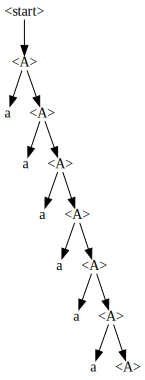

In [90]:
p = LeoParser(RR_GRAMMAR)
for tree in p.parse(mystring):
    assert all_terminals(tree, RR_GRAMMAR) == mystring
    display_tree(tree)

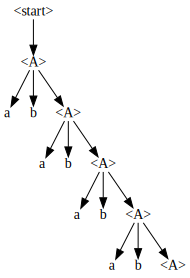

In [91]:
p = LeoParser(RR_GRAMMAR2)
for tree in p.parse(mystring2):
    assert all_terminals(tree, RR_GRAMMAR2) == mystring2
    display_tree(tree)

### Exercise 6 _First set of a nonterminal_

We previously gave a way to extract a the `nullable` (epsilon) set, which is often used for parsing.
Along with `nullable`, parsing algorithms often use two other sets [`first` and `follow`](https://en.wikipedia.org/wiki/Canonical_LR_parser#FIRST_and_FOLLOW_sets).
The first set of a terminal symbol is itself, and the first set of a nonterminal is composed of terminal symbols that can come at the beginning of any derivation
of that nonterminal. The first set of any nonterminal that can derive the empty string should contain `EPSILON`. For example, using our `A1_GRAMMAR`, the first set of both `<expr>` and `<start>` is `{0,1,2,3,4,5,6,7,8,9}`. The extraction first set for any self-recursive nonterminal is simple enough. One simply has to recursively compute the first set of the first element of its choice expressions. The computation of `first` set for a self-recursive nonterminal is tricky. One has to recursively compute the first set until one is sure that no more terminals can be added to the first set.

Can you implement the `first` set using our `fixpoint`?

The first set of all terminals is the set containing just themselves. So we initialize that first. Then we update the first set with rules that derive empty strings.

In [92]:
def firstset(grammar, nullable):
    first = {i: {i} for i in terminals(grammar)}
    for k in grammar:
        first[k] = {EPSILON} if k in nullable else set()
    return firstset_((rules(grammar), first, nullable))[1]

Finally, we rely on the `fixpoint` to update the first set with the contents of the current first set until the first set stops changing.

In [93]:
def first_expr(expr, first, nullable):
    tokens = set()
    for token in expr:
        tokens |= first[token]
        if token not in nullable:
            break
    return tokens


@fixpoint
def firstset_(arg):
    (rules, first, epsilon) = arg
    for A, expression in rules:
        first[A] |= first_expr(expression, first, epsilon)
    return (rules, first, epsilon)

In [94]:
firstset(canonical(EXPR_GRAMMAR_NS), EPSILON)

{'*': {'*'},
 '(': {'('},
 '3': {'3'},
 '5': {'5'},
 '6': {'6'},
 '7': {'7'},
 '-': {'-'},
 '9': {'9'},
 '2': {'2'},
 '/': {'/'},
 '4': {'4'},
 '+': {'+'},
 ')': {')'},
 '.': {'.'},
 '0': {'0'},
 '8': {'8'},
 '1': {'1'},
 '<start>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<expr>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<term>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<factor>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<integer>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<digit>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}}

### Exercise 7 _Follow set of a nonterminal_

The follow set definition is similar to the first set. The follow set of a nonterminal is the set of terminals that can occur just after that nonterminal is used in any derivation. The follow set of the start symbol is `EOF`, and the follow set of any nonterminal is the super set of first sets of all symbols that come after it in any choice expression.

For example, the follow set of `<expr>` in `A1_GRAMMAR` is the set `{EOF, +, -}`.

As in the previous exercise, implement the `followset` using `fixpoint`.

The implementation of `followset` is similar to the `firstset`. We first initialize the follow set with `EOF`, get the epsilon and first sets, and use the `fixpoint` to iteratively compute the follow set until nothing changes.

In [95]:
EOF = '\0'


def followset(grammar, start):
    follow = {i: set() for i in grammar}
    follow[start] = {EOF}

    epsilon = nullable(grammar)
    first = firstset(grammar, epsilon)
    return followset_((grammar, epsilon, first, follow))[-1]

Given the current follow set, one can update the follow set as follows:

In [96]:
@fixpoint
def followset_(arg):
    grammar, epsilon, first, follow = arg
    for A, expression in rules(grammar):
        f_B = follow[A]
        for t in reversed(expression):
            if t in grammar:
                follow[t] |= f_B
            f_B = f_B | first[t] if t in epsilon else (first[t] - {EPSILON})

    return (grammar, epsilon, first, follow)

In [97]:
followset(canonical(A1_GRAMMAR), START_SYMBOL)

{'<start>': {'\x00'},
 '<expr>': {'\x00', '+', '-'},
 '<integer>': {'\x00', '+', '-'},
 '<digit>': {'\x00',
  '+',
  '-',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'}}

### Exercise 8 _LL(1) parse table_

As we mentioned previously, there exist other kinds of parsers that operate left-to-right with right most derivation (*LR(k)*) or left-to-right with left most derivation (*LL(k)*) with _k_ signifying the amount of lookahead the parser is permitted to use.

What should one do with the lookahead? That lookahead can be used to determine which rule to apply. In the case of an *LL(1)* parser, the rule to apply is determined by looking at the _first_ set of the different rules. We previously implemented `first_expr` that takes a an expression, the set of  `nullables`, and computes the first set of that rule.

If a rule can derive an empty set, then that rule may also be applicable if of sees the `follow` set of the corresponding nonterminal.

Can you implement the parse table that describes what action to take for an *LL(1)* parser on seeing a terminal symbol on lookahead? The table should be in the form of a dictionary such that the keys represent the nonterminal symbol, and the value should contain another dict with keys as terminal symbols and the particular rule to continue parsing as the value.

The `parse_table` method populate a `self.table` data structure that should conform to the following requirements:

In [98]:
class LL1Parser(Parser):
    def parse_table(self):
        self.my_rules = rules(self.cgrammar)
        # .. fill in here to produce
        # self.table = ...
    
    def rules(self):
        for i, rule in enumerate(self.my_rules):
            print(i, rule)
            
    def show_table(self):
        ts = list(sorted(terminals(self.cgrammar)))
        print('Rule Name\t| %s' % ' | '.join(t for t in ts))
        for k in self.table:
            pr = self.table[k]
            actions = list(str(pr[t]) if t in pr else ' ' for t in ts)
            print('%s  \t| %s' % (k, ' | '.join(actions)))

On invocation of `LL1Parser(grammar).show_table()`
It should result in the following table:

In [99]:
for i, r in enumerate(rules(canonical(A2_GRAMMAR))):
    print("%d\t %s := %s" %(i, r[0], r[1]))

0	 <start> := ['<expr>']
1	 <expr> := ['<integer>', '<expr_>']
2	 <expr_> := ['+', '<expr>']
3	 <expr_> := ['-', '<expr>']
4	 <expr_> := []
5	 <integer> := ['<digit>', '<integer_>']
6	 <integer_> := ['<integer>']
7	 <integer_> := []
8	 <digit> := ['0']
9	 <digit> := ['1']
10	 <digit> := ['2']
11	 <digit> := ['3']
12	 <digit> := ['4']
13	 <digit> := ['5']
14	 <digit> := ['6']
15	 <digit> := ['7']
16	 <digit> := ['8']
17	 <digit> := ['9']



|Rule Name	|| + | - | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9|
|-----------||---|---|---|---|---|---|---|---|---|---|---|--|
|start  	||   |   | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0|
|expr  	||   |   | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1|
|expr_  	|| 2 | 3 |   |   |   |   |   |   |   |   |   |  |
|integer  	||   |   | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5|
|integer_  	|| 7 | 7 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6|
|digit  	||   |   | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17|    

We define `predict` as we explained before. Then use the predicted rules to populate the parse table.

In [100]:
class LL1Parser(LL1Parser):
    def predict(self, rulepair, first, follow, epsilon):
        A, rule = rulepair
        rf = first_expr(rule, first, epsilon)
        if nullable_expr(rule, epsilon):
            rf |= follow[A]
        return rf

    def parse_table(self):
        self.my_rules = rules(self.cgrammar)
        epsilon = nullable(self.cgrammar)
        first = firstset(self.cgrammar, epsilon)
        # inefficient, can combine the three.
        follow = followset(self.cgrammar, self.start_symbol)

        ptable = [(i, self.predict(rule, first, follow, epsilon))
                  for i,rule in enumerate(self.my_rules)]

        parse_tbl = {k: {} for k in self.cgrammar}

        for i, pvals in ptable:
            (k, expr) = self.my_rules[i]
            parse_tbl[k].update({v: i for v in pvals})

        self.table = parse_tbl

In [101]:
ll1parser = LL1Parser(A2_GRAMMAR)
ll1parser.parse_table()
ll1parser.show_table()

Rule Name	| + | - | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
<start>  	|   |   | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0
<expr>  	|   |   | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1
<expr_>  	| 2 | 3 |   |   |   |   |   |   |   |   |   |  
<integer>  	|   |   | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5
<integer_>  	| 7 | 7 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6
<digit>  	|   |   | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17


### Exercise 9 _LL(1) parser_

Once we have the parse table, implementing the parser is as follows: Consider the first item from the sequence of tokens to parse, and seed the stack with the start symbol.

While the stack is not empty, extract the first symbol from the stack, and if the symbol is a terminal, verify that the symbol matches the item from the input stream. If the symbol is a nonterminal, use the symbol and input item to lookup the next rule from the parse table. Insert the rule thus found to the top of the stack. Keep track of the expressions being parsed to build up the parse table.

Use the parse table defined previously to implement the complete LL(1) parser.

In [102]:
class LL1Parser(LL1Parser):
    def parse_helper(self, stack, inplst):
        inp, *inplst = inplst
        exprs = []
        while stack:
            val, *stack = stack
            if isinstance(val, tuple):
                exprs.append(val)
            elif val not in self.cgrammar:  # terminal
                assert val == inp
                exprs.append(val)
                inp, *inplst = inplst or [None]
            else:
                if inp is not None:
                    i = self.table[val][inp]
                    _, rhs = self.my_rules[i]
                    stack = rhs + [(val, len(rhs))] + stack
        return self.linear_to_tree(exprs)

    def parse(self, inp):
        self.parse_table()
        k, _ = self.my_rules[0]
        stack = [k]
        return self.parse_helper(stack, inp)

    def linear_to_tree(self, arr):
        stack = []
        while arr:
            elt = arr.pop(0)
            if not isinstance(elt, tuple):
                stack.append((elt, []))
            else:
                # get the last n
                sym, n = elt
                elts = stack[-n:] if n > 0 else []
                stack = stack[0:len(stack) - n]
                stack.append((sym, elts))
        assert len(stack) == 1
        return stack[0]

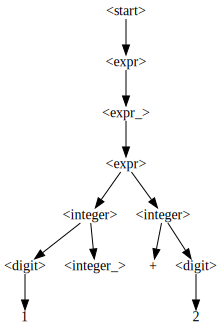

In [103]:
ll1parser = LL1Parser(A2_GRAMMAR)
tree = ll1parser.parse('1+2')
display_tree(tree)

### Exercise 10 A different LangFuzzer

Sometimes we do not want to use our pool of strings for various reasons -- the number of items in the pool may be inadequate, or not varied enough. Extend the `LangFuzzer` to use a separate function to check if the number of items in the pool corresponding to the selected non-terminal is large enough (say greater than 10), and if not, use the tree expansion technique from `GrammarFuzzer` to patch the hole.


Before we can make use of `GrammarFuzzer`, we need to change it a little bit. GrammarFuzzer relies on the grammar being in the `fuzzing` format with the expansions represented as strings. Our `LangFuzz` expects the expansions to be a list of tokens. So we fix the `GrammarFuzzer`.

In [104]:
class LangFuzzer2(LangFuzzer):
    def __init__(self, parser, strings):
        super().__init__(parser, strings)
        self.gfuzz = GrammarFuzzer(parser.grammar())

    def check_diversity(self, pool):
        return len(pool) > 10

    def candidate(self):
        tree, nodes = random.choice(self.trees)
        interesting_nodes = [
            n for n in nodes if nodes[n][0] in self.fragments
            and nodes[n][0] is not self.parser.start_symbol
            and len(self.fragments[nodes[n][0]]) > 0
        ]
        node = random.choice(interesting_nodes)
        return tree, node

    def generate_new_tree(self, node, choice):
        name, children, id = node
        if id == choice:
            pool = self.fragments[name]
            if self.check_diversity(pool):
                return random.choice(self.fragments[name])
            else:
                return None
        else:
            return (name,
                    [self.generate_new_tree(c, choice) for c in children])

    def fuzz(self):
        tree, node = self.candidate()
        tree_with_a_hole = self.generate_new_tree(tree, node)
        modified = self.gfuzz.expand_tree(tree_with_a_hole)
        return all_terminals(modified)

In [105]:
parser = EarleyParser(VAR_GRAMMAR, tokens=VAR_TOKENS)
lf = LangFuzzer2(parser, mystrings)
for i in range(100):
    print(lf.fuzz())

def abc;abc=12+(3+0.3)
def a;def b;a=1.3;a=a-1*(4+3+(2/a))
def a;def b;def c;a=1;b=2;c=a+a
def abc;abc=3+3.3
def avar;def bvar;avar=1.3;d=avar-3*(4+300)
def x;def y;def z;c=23;y=51;z=x*x-y*y
def a;def b;def c;def d;a=10;b=20;c=34;d=-b+(b*x-4*a*c)/(2*a)
def x;def y;def z;x=10;y=1;z=(x+y)*(x-y)
def a;def b;def c;bvar=avar-3*(4+300);b=2;c=a+b
def a;def b;def c;a=1;b=2;y=a+b
def avar;def bvar;avar=1.3;bvar=avar-x*(4+300)
def x;def y;def z;x=22;y=51;z=x*x-y*y
def abc;abc=12+(3+20)
def avar;def bvar;avar=1.3;bvar=avar-3*(4+34)
def x;def y;def z;x=a+b;y=20;z=(x+y)*(x-y)
def avar;def bvar;avar=1.3;bvar=avar-3*(4+100)
def x;def y;def z;x=10;y=20;z=(x+y)*(x-20)
def x;def y;def z;x=10;y=20;def z
def a;def b;a=1.3;b=a-1*(4+3+(2/bc))
def x;def y;def z;x=b*b-4*a*c;y=20;z=(x+y)*(x-y)
def a;def b;a=1.3;b=a-1*(4+3+(2/c))
def a;def b;def c;def d;a=10;b=20;c=34;d=-b+1.3
def y;def y;def z;x=23;y=51;z=x*x-y*y
def avar;def bvar;avar=1.3;bvax=avar-3*(4+300)
def x;def y;def z;x=10;y=20;z=(x+y)*(y-y)
def a;def

With these changes, our `LangFuzzer2` is able to use the pool of fragments when necessary, but can rely on the grammar when the pool is not sufficient.